<a href="https://colab.research.google.com/github/salmonin-o3o/ESAA_study/blob/main/250523_markdown.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

딥러닝 파이토치 교과서
## 5.2 합성곱 신경망 맛보기
fashion_mnist 데이터셋을 사용하여 합성곱 신경망을 직접 구현해보자.

In [1]:
#라이브러리 호출
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms # 데이터 전처리를 위해 사용하는 라이브러리
from torch.utils.data import Dataset, DataLoader

파이토치는 기본적으로 GPU 사용을 권장하지만, 지금은 CPU를 사용한다.

In [2]:
# CPU 혹은 GPU 장치 확인
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

+) GPU 사용
일반적으로 하나의 GPU를 사용할 때는 다음과 같은 코드를 이용한다.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"

model = Net()

model.to(device)

하지만 사용하는 PC에서 다수의 GPU를 사용한다면 다음 코드와 같이 nn.Parallel을 이용한다.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Net()

if torch.cuda.device_count() > 1:
  
  model = nn.DataParallel(net)

model.to(device)

이번 예제에서 사용한 fashion_mnist 데이터셋은 토치 비전으로 내려받을 수 있다.

In [3]:
# fashion_mnist 데이터셋 내려받기
train_dataset = torchvision.datasets.FashionMNIST('../chap05/data', download=True, transform=transforms.Compose([transforms.ToTensor()]))
# torchvision.datasets는 torch.utils.data.Dataset의 하위 클래스로 다양한 데이터셋을 포함한다.
test_dataset = torchvision.datasets.FashionMNIST('../chap05/data', download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))
# 앞에서는 훈련 데이터셋을 내려받았다면 여기에서는 테스트 데이터셋을 내려받는다.

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 300kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.60MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.10MB/s]


In [4]:
# fashion_mnist 데이터를 데이터로더에 전달
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
# torch.utils.data.DataLoader()를 사용하여 원하는 크기의 배치 단위로 데이터를 불러오거나, 순서가 무작위로 섞이도록 할 수 있다.
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

이 예제에서 다루고 있는 이미지를 살펴보자. 먼저 20개의 이미지를 레이블 정보와 함께 출력한다.

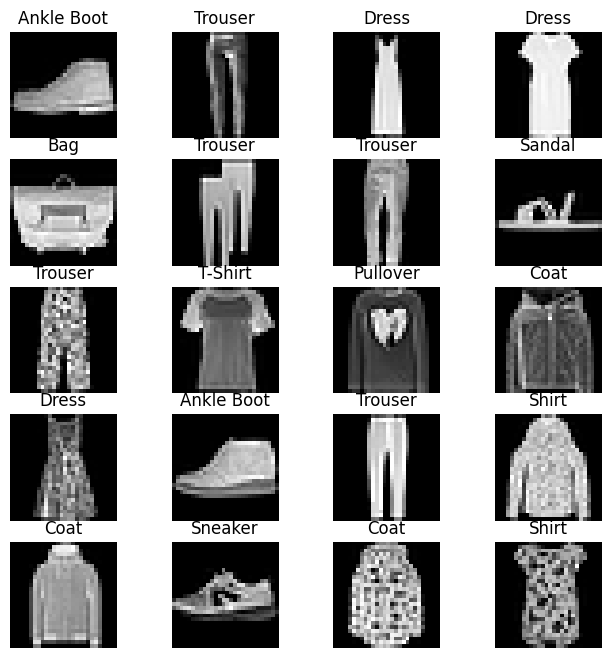

In [5]:
# 분류에 사용될 클래스 정의
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}
# 열 개의 클래스

fig = plt.figure(figsize=(8,8)); # 출력할 이미지의 가로세로 길이로 단위는 inch
columns = 4;
rows = 5;
for i in range(1, columns*rows + 1):
  img_xy = np.random.randint(len(train_dataset)); # 무작위로 데이터를 생성할 때 사용한다.
  img = train_dataset[img_xy][0][0,:,:] # train_dataset을 이용한 3차원 배열을 생성한다.
  fig.add_subplot(rows, columns, i)
  plt.title(labels_map[train_dataset[img_xy][1]])
  plt.axis('off')
  plt.imshow(img, cmap='gray')
plt.show() # 20개의 이미지 데이터를 시각적으로 표현

ranint는 임의의 숫자 출력, rand는 정규표준분포 난수를 행렬로 출력, randn은 가우시안 정규분포 난수를 행렬로 출력.

resize는 행렬의 크기를 조정

examp는 해당하는 요소들을 출력.

합성곱 신경망과 합성곱 신경망이 아닌 심층 신경망의 비교를 위해 먼저 심층 신경망을 생성한 후 학습시켜 보자. 즉, ConvNet이 적용되지 않은 네트워크를 먼저 만들어보자.

In [6]:
# 심층 신경망 모델 생성

class FashionDNN(nn.Module):
  def __init__(self): # 클래스 형태의 모델은 항상 torch.nn.Module을 상속받는다. 객체가 갖는 속성값을 초기화하며, 객체가 생성될 때 자동으로 호출된다.
    super(FashionDNN, self).__init__()
    self.fc1 = nn.Linear(in_features=784, out_features=256) # nn은 딥러닝 모델 구성에 필요한 모듈이 모여있는 패키지
    self.drop = nn.Dropout(0.25) # 0.25만큼의 비율로 텐서의 값이 0이 되고, 0이 되지 않는 값들은 기존 값에 (1/(1-0.25))만큼 곱해져 커진다.
    self.fc2 = nn.Linear(in_features=256, out_features=128)
    self.fc3 = nn.Linear(in_features=128, out_features=10)

  def forward(self, input_data): # 모델이 학습 데이터를 입력받아서 순전파 연산을 진행하는 함수
    out = input_data.view(-1, 784) # 넘파이의 reshape과 같은 역할
    out = F.relu(self.fc1(out)) # nn.xx와 nn.functional.xx는 다르다.
    out = self.drop(out)
    out = F.relu(self.fc2(out))
    out = self.fc3(out)
    return out

+) 객체

객체 지향 프로그래밍은 프로그래밍에서 필요한 데이터를 추상화하여 속성이나 행동, 동작, 특징 등을 객체로 만들고, 그 객체들이 서로 유기적으로 동작하도록 하는 프로그래밍 방법이다. 이때 객체란 메모리를 할당받아 프로그램에서 사용되는 모든 데이터를 의미하기 때문에 변수, 함수 등은 모두 객체라고 할 수 있다.

+) 클래스와 함수

함수란 하나의 특정 작업을 수행하기 위해 독립적으로 설계된 프로그램 코드이다.

함수뿐만 아니라 관련된 변수까지도 한꺼번에 묶어서 관리하고 재사용할 수 있게 해주는 것이 클래스이다.

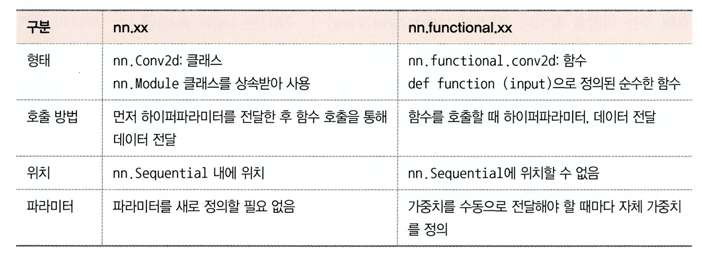

In [7]:
# 심층 신경망에서 필요한 파라미터 정의
learning_rate = 0.001;
model = FashionDNN();
model.to(device)

criterion = nn.CrossEntropyLoss(); # 분류 문제에서 사용하는 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate); # 옵티마이저를 위한 경사하강법은 Adam을 사옹.
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [8]:
# 심층 신경망을 이용한 모델 학습
num_epochs = 5
count = 0
loss_list = [] ## 비어 있는 배열이나 행렬을 만들고,
iteration_list = []
accuracy_list = []

prediction_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader: # for 구문을 사용하여 레코드를 하나씩 가져온다.
        images, labels = images.to(device), labels.to(device) # 모델과 데이터가 동일한 장치에 있어야한다.

        train = Variable(images.view(100, 1, 28, 28)) # Autograd의 Variable을 사용해서 역전파를 위한 미분 값을 자동으로 계산해준다.
        labels = Variable(labels)

        outputs = model(train) # 학습 데이터를 모델에 적용
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50): # count를 50으로 나누었을 때 나머지가 0이 아니라면 실행
          total = 0
          correct = 0
          for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            labels_list.append(labels)
            test = Variable(images.view(100, 1, 28, 28))
            outputs = model(test)
            predictions = torch.max(outputs, 1)[1].to(device)
            prediction_list.append(predictions)
            correct += (predictions == labels).sum()
            total += len(labels)

          accuracy = correct * 100 /  total # 정확도
          loss_list.append(loss.data) ## append 메서드를 이용하여 데이터를 하나씩 추가한다.
          iteration_list.append(count)
          accuracy_list.append(accuracy)

        if not (count % 500):
          print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.5866716504096985, Accuracy: 82.91999816894531%
Iteration: 1000, Loss: 0.5293229222297668, Accuracy: 84.98999786376953%
Iteration: 1500, Loss: 0.3257265090942383, Accuracy: 84.86000061035156%
Iteration: 2000, Loss: 0.3810529410839081, Accuracy: 85.12000274658203%
Iteration: 2500, Loss: 0.28298917412757874, Accuracy: 85.55000305175781%
Iteration: 3000, Loss: 0.30699262022972107, Accuracy: 86.5%


최종적으로 정확도가 86%로 높은 수치를 보여준다. 이제 합성곱 신경망을 생성해보자.

In [9]:
# 합성곱 네트워크 생성
class FashionCNN(nn.Module):
  def __init__(self):
    super(FashionCNN, self).__init__()
    self.layer1 = nn.Sequential( # 계층을 차례로 쌓을 수 있도록 수식과 활성화 함수를 연결해주는 역할을 한다.
      nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1), # 합성곱층
      nn.BatchNorm2d(32), # 각 배치 단위별로 데이터가 다양한 분포를 가지더라도 평균과 분산을 이용하여 정규화
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2) # 이미지 크기를 축소
    )
    self.layer2 = nn.Sequential(
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(2)
    )
    self.fc1 = nn.Linear(in_features=64*6*6, out_features=600) # 이미지 형태의 데이터를 배열 형태로 변환하여 작업한다.
    self.drop = nn.Dropout2d(0.25)
    self.fc2 = nn.Linear(in_features=600, out_features=120)
    self.fc3 = nn.Linear(in_features=120, out_features=10) # 마지막 계층의 out_features는 클래스 개수를 의미

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0), -1) # 합성곱층에서 완전연결층으로 변경되기 때문에 데이터의 형태를 1차원으로 바꾸어준다.
    out = self.fc1(out)
    out = self.drop(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out

self.fc1 = nn.Linear(in_features=64*6*6, out_features=600) # 이미지 형태의 데이터를 배열 형태로 변환하여 작업한다.

에서, Conv2d에서 사용하는 하이퍼파라미터 값들에 따라 출력 크기가 달라진다. 즉, 패딩과 스트라이드의 값에 따라 출력 크기가 달라진다.

**Conv2d 계층에서 출력 크기 구하는 공식**

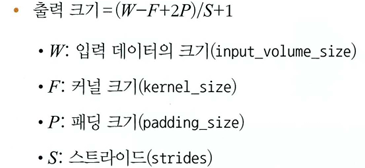

**MaxPool2d 계층에서의 출력 크기 구하는 공식**

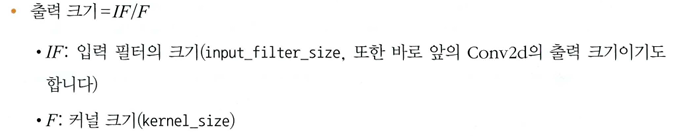


In [10]:
# 합성곱 네트워크를 위한 파라미터 정의
learning_rate = 0.001;
model = FashionCNN();
model.to(device)

critertion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [13]:
# 모델 학습 및 성능 평가
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
  for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)

      train = Variable(images.view(100, 1, 28, 28))
      labels = Variable(labels)

      outputs = model(train)
      loss = critertion(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      count += 1

      if not (count % 50):
        total = 0
        correct = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            labels_list.append(labels)
            test = Variable(images.view(100, 1, 28, 28))
            outputs = model(test)
            predictions = torch.max(outputs, 1)[1].to(device)
            predictions_list.append(predictions)
            correct += (predictions == labels).sum()
            total += len(labels)

        accuracy = correct * 100 / total
        loss_list.append(loss.data)
        iteration_list.append(count)
        accuracy_list.append(accuracy)

      if not (count % 500):
        print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.43506959080696106, Accuracy: 87.55999755859375%
Iteration: 1000, Loss: 0.2868320047855377, Accuracy: 89.23999786376953%
Iteration: 1500, Loss: 0.3529807925224304, Accuracy: 87.9800033569336%
Iteration: 2000, Loss: 0.22733840346336365, Accuracy: 89.26000213623047%
Iteration: 2500, Loss: 0.1266433745622635, Accuracy: 89.91999816894531%
Iteration: 3000, Loss: 0.16615024209022522, Accuracy: 90.48999786376953%


심층 신경망과 비교하여 정확도가 약간 높다. 이미지 데이터가 많아지면 단순 심픙 신경망으로는 정확한 특성 추출 및 분류가 불가능하므로 합성곱 신경망을 생성할 수 있도록 학습해야한다.